# Book Recommender System

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import GraphConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data investigation

In [3]:
ratings = pd.read_csv("Data/Ratings.csv")
#print(f"{ratings.dtypes}\n")
#print(ratings.head())
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [4]:
ratings["Book-Rating"].value_counts()

Book-Rating
0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: count, dtype: int64

In [5]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].mean())
print(average_rating)
print(type(average_rating))

             Book-Rating
ISBN                    
 0330299891          3.0
 0375404120          1.5
 0586045007          0.0
 9022906116          3.5
 9032803328          0.0
...                  ...
cn113107             0.0
ooo7156103           7.0
§423350229           0.0
´3499128624          8.0
Ô½crosoft            7.0

[340556 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [6]:
average_rating.sort_values(by=['Book-Rating'], ascending=False, inplace=True)
average_rating.rename(columns={'Book-Rating':'Average-Rating'}, inplace=True)
print(average_rating.head(10))

            Average-Rating
ISBN                      
0874477050            10.0
561002010             10.0
0590939874            10.0
1570761914            10.0
56500624X             10.0
157076154X            10.0
1570761175            10.0
0373510365            10.0
0393092526            10.0
0590936026            10.0


In [8]:
# Round ratings to the nearest 0.1 and sum the occurrences
average_rating['Rounded-Rating'] = average_rating['Average-Rating'].round(decimals=1)
rating_counts = average_rating.groupby('Rounded-Rating').size()

# Remove the rating 0
if 0 in rating_counts:
    rating_counts = rating_counts.drop(0)

# Create a DataFrame from the grouped data
ratings_df = pd.DataFrame({'Rating': rating_counts.index, 'Count': rating_counts.values})

# Interpolate data for missing ratings for a smoother line
ratings_df.set_index('Rating', inplace=True)
ratings_df = ratings_df.reindex(np.arange(0.1, 10.1, 0.1), fill_value=0)

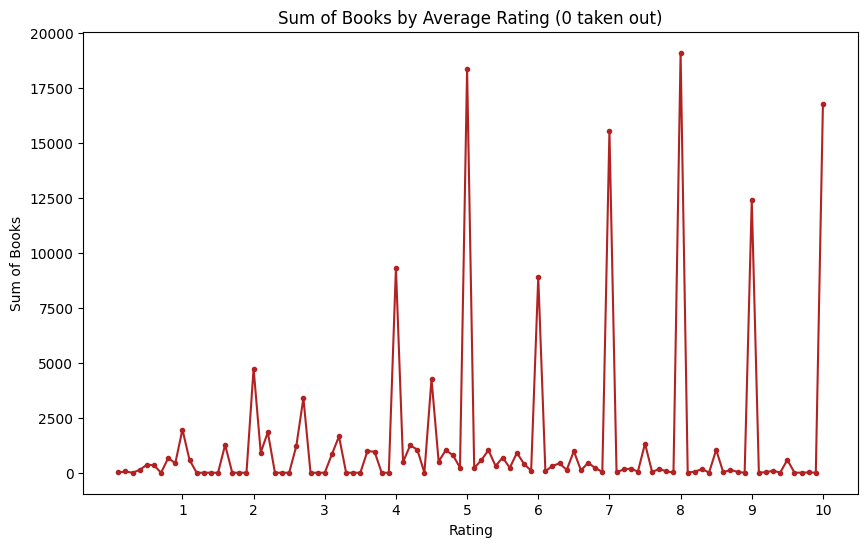

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ratings_df.index, ratings_df['Count'], marker='.', linestyle='-', color='firebrick')
plt.xlabel('Rating')
plt.ylabel('Sum of Books')
plt.title('Sum of Books by Average Rating (0 taken out)')
plt.xticks(np.arange(1, 11, 1))  # Set x-axis ticks to show each integer from 1 to 10
plt.show()

In [6]:
books = pd.read_csv("Data/Books.csv", dtype={3: str})
#print(f"Books Data Shape: {books.shape} \n")
#print(f"{books.dtypes}\n")
#print(books.head(3))

books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [7]:
print('Nan-values by column')
print(books.isna().sum())

Nan-values by column
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [6]:
users = pd.read_csv("Data/Users.csv")
#print(f"Users Data Shape: {users.shape} \n")
#print(f"{users.dtypes}\n")
#print(users.head())
#print('Nan-values by column')
#print(users.isna().sum())

users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


## Preprocessing

In [7]:
# We will only use users and books present in the ratings dataset 
lessen_user_ids = {userid: idx for idx, userid in enumerate(ratings['User-ID'].unique())} #renumber IDs to reduce inactive users
ratings['New-User-ID'] = ratings['User-ID'].map(lessen_user_ids)
user_ids = list(ratings['New-User-ID'].unique())
num_users = len(set(user_ids))

# Map book identifiers (ISBN) to a unique integer identifier for datatype compatibility of dgl
isbn_to_id = {isbn: idx for idx, isbn in enumerate(ratings['ISBN'].unique())}
ratings['Book-ID'] = ratings['ISBN'].map(isbn_to_id)
book_ids = list(ratings['Book-ID'].unique())
num_books = len(set(book_ids))

print(f'There are {len(user_ids)} unique users, and {len(book_ids)} unique books in the ratings dataset.')
 
# Remove users and books not included in the ratings dataset
books['Book-ID'] = books['ISBN'].map(isbn_to_id)
books_clean = books[books['Book-ID'].isin(book_ids)]
books_clean_ids = books_clean['Book-ID'].unique()
percent_books_missing = round((num_books-len(books_clean_ids))/num_books*100, 0)

print(f'There are around {percent_books_missing}% of books in the graph missing in the books data')

users['New-User-ID'] = users['User-ID'].map(lessen_user_ids)
users_clean = users[users['New-User-ID'].isin(user_ids)]

There are 105283 unique users, and 340556 unique books in the ratings dataset.
There are around 21.0% of books in the graph missing in the books data


1/5 of the books that have rating information do not have further information on the books dataset. However, as our objective is to investigate a user-based recommender system, this is irrelevant. We are able to embed the age and location data of users. As the age data is sparse, location data will be our main source of information.

## User-Based Collaborative Filtering

The following is based on [this Kaggle documentation](https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101)

"This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person."

In [8]:
ratings_with_book_titles = ratings.merge(books,on='ISBN')
ratings_with_book_titles.drop(columns=["ISBN","Image-URL-S","Image-URL-M"],axis=1,inplace=True)
complete_df = ratings_with_book_titles.merge(users.drop("Age", axis=1), on="User-ID")

In [9]:
complete_df['Location'] = complete_df['Location'].str.split(',').str[-1].str.strip()
complete_df.head()

,User-ID,Book-Rating,New-User-ID_x,Book-ID_x,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,Book-ID_y,Location,New-User-ID_y
0,276725,0,0,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,0.0,usa,0.0
1,2313,5,1655,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,0.0,usa,1655.0
2,2313,9,1655,383,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,383.0,usa,1655.0
3,2313,8,1655,443,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,443.0,usa,1655.0
4,2313,9,1655,1313,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,1313.0,usa,1655.0


In [10]:
# Select user IDs with more than 200 book ratings
min_ratings_threshold = 200

# Count book ratings per user
num_ratings_per_user = complete_df.groupby('User-ID')['Book-Rating'].count()

# Filter users with more than the minimum threshold
knowledgeable_user_ids = num_ratings_per_user[num_ratings_per_user > min_ratings_threshold].index

In [11]:
# Filter ratings from knowledgeable users
knowledgeable_user_ratings = complete_df[complete_df['User-ID'].isin(knowledgeable_user_ids)]

In [12]:
min_ratings_count_threshold=50
rating_counts= knowledgeable_user_ratings.groupby('Book-Title').count()['Book-Rating']
popular_books = rating_counts[rating_counts >= min_ratings_count_threshold].index

In [13]:
final_ratings =  knowledgeable_user_ratings[knowledgeable_user_ratings['Book-Title'].isin(popular_books)]

In [14]:
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID'
                          ,values='Book-Rating')
pt.fillna(0,inplace=True)
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.metrics.pairwise import cosine_similarity 

In [16]:
similarity_score = cosine_similarity(pt)

In [17]:
def recommend(book_name):
    index = np.where(pt.index==book_name)[0][0]
    similar_books = sorted(list(enumerate(similarity_score[index])),key=lambda x:x[1], reverse=True)[1:6]
    
    data = []
    
    for i in similar_books:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
 
        data.append(item)
    return data

In [18]:
recommend("The Catcher in the Rye")

[["The Hitchhiker's Guide to the Galaxy", 'Douglas Adams'],
 ['The Nanny Diaries: A Novel', 'Emma McLaughlin'],
 ['A Wrinkle in Time', "Madeleine L'Engle"],
 ['To Kill a Mockingbird', 'Harper Lee'],
 ['Tis: A Memoir', 'Frank McCourt']]

In [19]:
# Install Surprise library
!pip install scikit-surprise

In [20]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Define the rating scale
reader = Reader(rating_scale=(0, 10))

# Load the data into Surprise's dataset format
data = Dataset.load_from_df(complete_df[['User-ID', 'Book-Title', 'Book-Rating']], reader)

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(data, test_size=0.20, random_state=42)

# Define the SVD algorithm
model = SVD()

# Train the algorithm on the training set
model.fit(train_set)

# Make predictions on the test set
predictions = model.test(test_set)

## Evaluations

In [21]:
# Evaluate the model
accuracy.rmse(predictions)

RMSE: 3.5174


3.5174476915007853

In [22]:
from collections import defaultdict
from surprise import accuracy

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

def calculate_f1(precisions, recalls):
    f1_scores = {}
    for uid in precisions:
        if precisions[uid] + recalls[uid] > 0:
            f1_scores[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
        else:
            f1_scores[uid] = 0
    return f1_scores

precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4.0)
f1_scores = calculate_f1(precisions, recalls)

avg_precision = sum(precisions.values()) / len(precisions)
avg_recall = sum(recalls.values()) / len(recalls)
avg_f1 = sum(f1_scores.values()) / len(f1_scores)

print(f'Precision@10: {avg_precision:.4f}')
print(f'Recall@10: {avg_recall:.4f}')
print(f'F1 Score@10: {avg_f1:.4f}')

Precision@10: 0.8661
Recall@10: 0.5048
F1 Score@10: 0.4546


In [23]:
def mean_average_precision(predictions, k=10):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    average_precisions = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel_and_rec_k = sum(1 for (est, true_r) in user_ratings[:k] if true_r >= 4.0)
        precisions_at_k = [sum(1 for (est, true_r) in user_ratings[:i+1] if true_r >= 4.0) / (i + 1) for i in range(k)]
        average_precision = sum(precisions_at_k[:n_rel_and_rec_k]) / min(k, n_rel_and_rec_k) if n_rel_and_rec_k != 0 else 0
        average_precisions.append(average_precision)

    return sum(average_precisions) / len(average_precisions)

# Example usage
map_score = mean_average_precision(predictions, k=10)
print(f'MAP@10: {map_score:.4f}')

MAP@10: 0.5460


## Content-Based 

The following code is based on [this Kaggle documentation](https://www.kaggle.com/code/hilalmleykeyuksel/book-recommender#CONTENT-BASED-COLLABORATIVE-FILTERING)

In [24]:
import re
df=complete_df.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["Year-Of-Publication"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,User-ID,Book-Rating,New-User-ID_x,Book-ID_x,Book-Title,Book-Author,Publisher,Image-URL-L,Book-ID_y,Location,New-User-ID_y
1,2313,5,1655,0,Flesh Tones A Novel,M. J. Rose,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,0.0,usa,1655.0
2,2313,9,1655,383,Ender s Game Ender Wiggins Saga Paperback,Orson Scott Card,Tor Books,http://images.amazon.com/images/P/0812533550.0...,383.0,usa,1655.0
3,2313,8,1655,443,In Cold Blood Vintage International,TRUMAN CAPOTE,Vintage,http://images.amazon.com/images/P/0679745580.0...,443.0,usa,1655.0
4,2313,9,1655,1313,Divine Secrets of the Ya Ya Sisterhood A Novel,Rebecca Wells,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,1313.0,usa,1655.0
5,2313,5,1655,1545,The Mistress of Spices,Chitra Banerjee Divakaruni,Anchor Books/Doubleday,http://images.amazon.com/images/P/0385482388.0...,1545.0,usa,1655.0


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
def content_based(bookTitle):
    bookTitle = str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count = pd.DataFrame(df["Book-Title"].value_counts())
        rare_books = rating_count[rating_count["Book-Title"] <= 200].index
        common_books = df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common = pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n")
            print("YOU MAY TRY: \n")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books = common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"] = [i for i in range(common_books.shape[0])]
            targets = ["Book-Title", "Book-Author", "Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
            vectorizer = CountVectorizer()
            common_booksVector = vectorizer.fit_transform(common_books["all_features"])
            similarity = cosine_similarity(common_booksVector)
            index = common_books[common_books["Book-Title"] == bookTitle]["index"].values[0]
            similar_books = list(enumerate(similarity[index]))
            similar_booksSorted = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:6]
            books = []
            for i in range(len(similar_booksSorted)):
                books.append([common_books[common_books["index"] == similar_booksSorted[i][0]]["Book-Title"].item(),
                              common_books[common_books["index"] == similar_booksSorted[i][0]]["Book-Author"].item()])
            print(books)

    else:
        print("error")

In [28]:
content_based("The Catcher in the Rye")

[['The Fellowship of the Ring The Lord of the Rings Part 1', 'J.R.R. TOLKIEN'], ['The Lovely Bones A Novel', 'Alice Sebold'], ['The Da Vinci Code', 'Dan Brown'], ['Harry Potter and the Order of the Phoenix Book 5', 'J. K. Rowling'], ['The Five People You Meet in Heaven', 'Mitch Albom']]


In [31]:
# Import necessary libraries from Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

# Load the data into Surprise's dataset format
reader = Reader(rating_scale=(0, 10))
data2 = Dataset.load_from_df(df[['User-ID', 'Book-Title', 'Book-Rating']], reader)

# Split the dataset into training and testing sets
train2_set, test2_set = train_test_split(data2, test_size=0.20, random_state=42)

# Define the SVD algorithm
model = SVD()

# Train the algorithm on the training set
model.fit(train2_set)

# Make predictions on the test set
predictions2 = model.test(test2_set)

# Evaluate the model
rmse2 = accuracy.rmse(predictions2)

RMSE: 1.6310


In [34]:
precisions, recalls = precision_recall_at_k(predictions2, k=10, threshold=4.0)
f1_scores = calculate_f1(precisions, recalls)

avg_precision = sum(precisions.values()) / len(precisions)
avg_recall = sum(recalls.values()) / len(recalls)
avg_f1 = sum(f1_scores.values()) / len(f1_scores)

print(f'Precision@10: {avg_precision:.4f}')
print(f'Recall@10: {avg_recall:.4f}')
print(f'F1 Score@10: {avg_f1:.4f}')

Precision@10: 0.9707
Recall@10: 0.9803
F1 Score@10: 0.9602


In [35]:
map_score2 = mean_average_precision(predictions2, k=10)
print(f'MAP@10: {map_score2:.4f}')

MAP@10: 0.9722


# Setting up data structures for GNN

In [ ]:
# Make graph
src = torch.tensor(ratings['New-User-ID'].values)
dst = torch.tensor(ratings['Book-ID'].values)

edges = {
    ('user', 'rating', 'book'): (src, dst)
}

g = dgl.heterograph(edges, num_nodes_dict={'user': num_users, 'book': num_books})
print(g)

In [ ]:
# Weight the edges by ratings
rating_data = ratings['Book-Rating'].values
ratings_tensor = torch.tensor(rating_data, dtype=torch.float32)
g.edges['rating'].data['rating'] = ratings_tensor 

In [ ]:
# Add age to user feature
ages = users_clean['Age'].values
ages_tensor = torch.tensor(ages, dtype=torch.float32)
g.nodes['user'].data['age'] = ages_tensor

We extract the country from the location by obtaining the expression after the last comma in e.g. nyc, new york, usa

In [ ]:
users_clean['Country'] = users_clean['Location'].str.rsplit(',', n=1).str[-1].str.strip()
country_counts = users_clean['Country'].value_counts(normalize=True) 

# We see that less frequent locations do not always contain country names, so we remove values of locations representing less than 1%
rare_countries = country_counts[country_counts < 0.01].index
users_clean.loc[users_clean['Country'].isin(rare_countries), 'Country'] = np.nan

country_ids = {country: idx for idx, country in enumerate(users_clean['Country'].unique())}  # map country to a unique integer
users_clean['CountryId'] = users_clean['Country'].map(country_ids)
countries = users_clean['CountryId'].values
countries_tensor = torch.tensor(countries, dtype=torch.float32)
g.nodes['user'].data['country'] = countries_tensor

In [ ]:
print(g.nodes['user'])
print(g.nodes['book'])

### Basic graph info

In [ ]:
print(g)  # Prints the basic info of the graph, such as number of nodes and edges per type

# Print number of nodes for each type
print("Number of users:", g.number_of_nodes('user'))
print("Number of books:", g.number_of_nodes('book'))

# Print number of edges
print("Number of ratings:", g.number_of_edges('rating'))

### Node and Edge feature inspection

In [ ]:
# Print user node features
print("User features:", g.nodes['user'].data.keys())

# Print book node features, if any
print("Book features:", g.nodes['book'].data.keys())

# Print edge features
print("Edge features:", g.edges['rating'].data.keys())

# Example to print specific feature details:
print("Sample user ages:", g.nodes['user'].data['age'][:5])  # prints first 5 user ages
print("Sample ratings:", g.edges['rating'].data['rating'][:5])  # prints first 5 ratings

### Eliminate isolated nodes if any

In [ ]:
compact_g = dgl.compact_graphs(g)

### Create synthetic features for book based on degree of the node

In [ ]:
book_in_degrees = g.in_degrees(etype=('user', 'rating', 'book')).float().unsqueeze(1)

In [ ]:
g.nodes['book'].data['in_degree'] = book_in_degrees

In [ ]:
data = g
data

In [ ]:
node_types = g.ntypes
edge_types = g.etypes
print("Node types:", node_types)
print("Edge types:", edge_types)
print('Number of rating edges:', g.number_of_edges('rating'))

# Creating the GNN

## Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

class GNNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_channels):
        super(GNNEncoder, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_channels, 'mean')
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, 'mean')

    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.conv2(g, h)
        print(f"Encoder output shape: {h.shape}")  # Debugging output
        return h

class BookEmbedding(nn.Module):
    def __init__(self, num_books, embedding_dim):
        super(BookEmbedding, self).__init__()
        self.book_embedding = nn.Embedding(num_books, embedding_dim)

    def forward(self, book_ids):
        embeddings = self.book_embedding(book_ids)
        print(f"Book embedding shape: {embeddings.shape}") 
        return embeddings

class EdgeDecoder(nn.Module):
    def __init__(self, hidden_channels):
        super(EdgeDecoder, self).__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, g, h_user, h_book):
        with g.local_scope():
            g.nodes['user'].data['h'] = h_user
            g.nodes['book'].data['h'] = h_book
            
            # Ensure edge function is only applied where it should be
            if 'rating' in g.etypes:
                g.apply_edges(func=lambda edges: {
                    'score': self.lin2(F.relu(self.lin1(torch.cat([edges.src['h'], edges.dst['h']], dim=1))))
                }, etype='rating')
            return g.edata.get('score', torch.tensor([]))  # Handle case where no edges exist


class Model(nn.Module):
    def __init__(self, num_books, in_feats_user, hidden_channels):
        super(Model, self).__init__()
        self.user_encoder = GNNEncoder(in_feats_user, hidden_channels)
        self.book_embedding = BookEmbedding(num_books, hidden_channels)
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, g, user_features, book_ids):
        h_user = self.user_encoder(g, user_features)
        h_book = self.book_embedding(book_ids)
        return self.decoder(g, h_user, h_book)

## Split graph for training and validation set

In [ ]:
def split_graph(g, proportion=0.8):
    # Split edges randomly for training and validation
    num_edges = g.number_of_edges('rating')
    all_edges = np.arange(num_edges)
    np.random.shuffle(all_edges)
    
    train_size = int(num_edges * proportion)
    train_edges = all_edges[:train_size]
    val_edges = all_edges[train_size:]
    
    # Create subgraphs based on the edges
    g_train = dgl.edge_subgraph(g, train_edges, relabel_nodes=False)
    g_val = dgl.edge_subgraph(g, val_edges, relabel_nodes=False)
    
    return g_train, g_val

In [ ]:
g_train, g_val = split_graph(g, proportion=0.8)

age_tensor_val = g_val.nodes['user'].data['age'].unsqueeze(1)
country_tensor_val = g_val.nodes['user'].data['country'].unsqueeze(1)
user_features_val = torch.cat([age_tensor_val, country_tensor_val], dim=1)

# Assuming book_ids are just the indices of the books, adjust if necessary
book_ids_train = torch.arange(g_train.number_of_nodes('book'))
book_ids_val = torch.arange(g_val.number_of_nodes('book'))

## Train

`criterion` - MSE loss that calculates the average squared difference between the predicted outputs and the actual target values.

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
book_ids_train = g_train.nodes['book'].data['orig_id']
book_ids_val = g_val.nodes['book'].data['orig_id']

In [ ]:
def train(model, g, user_features, book_ids, ratings, optimizer, criterion):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients before each backward pass

    # Move data to the correct device
    g = g.to(device)
    user_features = user_features.to(device)
    book_ids = book_ids.to(device)
    ratings = ratings.to(device)

    # Forward pass
    predictions = model(g, user_features, book_ids)
    loss = criterion(predictions, ratings)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def validate(model, g, user_features, book_ids, ratings, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation, which saves memory and computations
        g = g.to(device)
        user_features = user_features.to(device)
        book_ids = book_ids.to(device)
        ratings = ratings.to(device)

        # Forward pass
        predictions = model(g, user_features, book_ids)
        loss = criterion(predictions, ratings)

    return loss.item()

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, g_train, user_features_train, book_ids_train, ratings_train, optimizer, criterion)
    val_loss = validate(model, g_val, user_features_val, book_ids_val, ratings_val, criterion)
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

## Evaluate model

In [ ]:
def evaluate(model, g, user_features, book_features, labels, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(g, user_features, book_features)
        loss = criterion(outputs, labels)
    return loss.item()

In [ ]:
# Validation loss
validation_loss = evaluate(model, g_val, user_features_val, book_features_val, ratings_val, criterion)
print(f'Validation Loss: {validation_loss}')